## CNN model

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### 重置與載入模型

In [3]:
#重置
tf.reset_default_graph()

In [4]:
input_dim = 28*28
output_dim = 10

x = tf.placeholder("float",[None, input_dim])
y = tf.placeholder("float",[None, output_dim])
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [5]:
learning_rate = 0.001
training_epochs = 1
batch_size = 200

MLP_input_dim = 7*7*36
hidden1_dim = 256
hidden2_dim = 256

In [6]:
with tf.name_scope('Convolution_layer1'):
    W_conv1 = tf.Variable(tf.random_normal([5, 5, 1, 16]), name='Conv1_weight')
    b_conv1 = tf.Variable(tf.random_normal([16]), name='Conv1_bias')
    conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME'), b_conv1))

with tf.name_scope('Max-pooling_layer1'):
    max_pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

with tf.name_scope('Convolution_layer2'):
    W_conv2 = tf.Variable(tf.random_normal([5, 5, 16, 36]), name='Conv2_weight')
    b_conv2 = tf.Variable(tf.random_normal([36]), name='Conv2_bias')
    conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(max_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME'), b_conv2))

with tf.name_scope('Max-pooling_layer2'):
    max_pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

with tf.name_scope('Flatten_layer'):
    flatten = tf.reshape(max_pool2, [-1, 7 * 7 * 36])

with tf.name_scope('InputLayer_to_HiddenLayer1'):
    w1 = tf.Variable(tf.random_normal([MLP_input_dim, hidden1_dim]),name='weight1')
    b1 = tf.Variable(tf.random_normal([hidden1_dim]),name='bias1')
    a1 = tf.nn.relu(tf.add(tf.matmul(flatten,w1),b1))

with tf.name_scope('HiddenLayer1_to_HiddenLayer2'):
    # input layer to hidden layer 2
    w2 = tf.Variable(tf.random_normal([hidden1_dim, hidden2_dim]),name='weight2')
    b2 = tf.Variable(tf.random_normal([hidden2_dim]),name='bias2')
    a2 = tf.nn.relu(tf.add(tf.matmul(a1,w2),b2))

with tf.name_scope('HiddenLayer2_to_OutputLayer'):
    # hidden layer 2 to output layer
    w3 = tf.Variable(tf.random_normal([hidden2_dim, output_dim]),name='weight3')
    b3 = tf.Variable(tf.random_normal([output_dim]),name='bias3')
    y_pred = tf.add(tf.matmul(a2,w3),b3) # output function
    
with tf.name_scope('Loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_pred))
    tf.summary.scalar("loss", loss)

with tf.name_scope('Accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    tf.summary.scalar("accuracy", accuracy)

with tf.name_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

merged_summary = tf.summary.merge_all()   

### 載入預存的變數值進行預測

In [7]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Restore variables from disk.
    saver.restore(sess, "save_model/cnn_model.ckpt")
    # Test Dataset
    print ("Test Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))  


INFO:tensorflow:Restoring parameters from save_model/cnn_model.ckpt
Test Accuracy: 0.9859


In [8]:
mnist.test.images.shape

(10000, 784)

In [9]:
mnist.test.images[0:1,].shape

(1, 784)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(np.reshape(images[idx],(28, 28)), cmap='binary')
        
        title=""
        if len(labels)>0:
            title= "label=" +str(np.argmax(labels[idx]))
        
        if len(prediction)>0:
            title+=" predict="+str(prediction[idx])
            
        ax.set_title(title,fontsize=10)
        ax.set_xticks([]);ax.set_yticks([])
        idx+=1
    plt.show()

In [11]:
mnist.test.labels.shape

(10000, 10)

INFO:tensorflow:Restoring parameters from save_model/cnn_model.ckpt


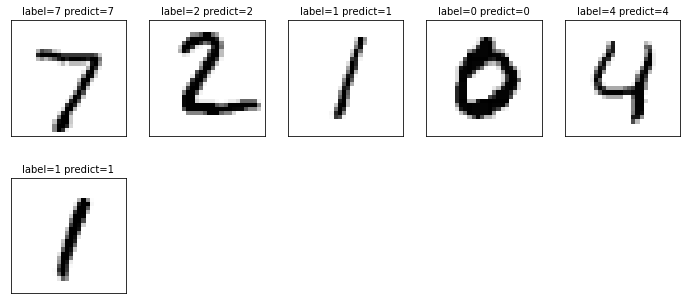

predict result: [7 2 1 0 4 1]


In [12]:
from matplotlib import pyplot as plt
from random import randint

imgs = mnist.test.images[0:6,]
labs = mnist.test.labels[0:6,]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Restore variables from disk.
    saver.restore(sess, "save_model/cnn_model.ckpt")
    pred_result = sess.run(tf.argmax(y_pred,1), feed_dict={x: imgs, y: labs})

    plot_images_labels_prediction(imgs, labs, pred_result,0,6)
    print("predict result:",pred_result)

### 取得網頁上的證驗碼圖片

In [13]:
import cv2
import requests

In [31]:
with open('img/kaptcha.jpg','wb') as f:
    res = requests.get('http://gcis.nat.gov.tw/pub/kaptcha.jpg')
    f.write(res.content)

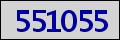

In [32]:
from PIL import Image
image = Image.open('img/kaptcha.jpg')
image

In [33]:
import PIL
import numpy
pil_image = PIL.Image.open('img/kaptcha.jpg').convert('RGB')
open_cv_image = numpy.array(pil_image)

In [34]:
open_cv_image.shape

(40, 120, 3)

In [35]:
type(open_cv_image)

numpy.ndarray

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


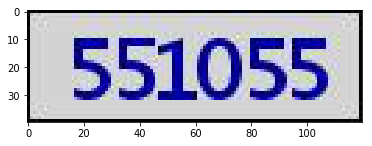

In [36]:
%pylab inline
from matplotlib import pyplot as plt
plt.imshow(open_cv_image)

In [37]:
imgray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cnts = sorted([(_c, cv2.boundingRect(_c)[0]) for _c in contours], key=lambda _x:_x[1])

ary = []
for (_c,_) in cnts:
    (_x,_y,_w,_h) = cv2.boundingRect(_c)
    print((_x,_y,_w,_h))
    if _w >= 15 and _h == 24:
        ary.append((_x,_y,_w,_h))

(1, 1, 118, 38)
(16, 9, 15, 24)
(32, 9, 15, 24)
(46, 9, 16, 24)
(60, 9, 18, 24)
(65, 13, 8, 16)
(79, 9, 15, 24)
(94, 9, 15, 24)


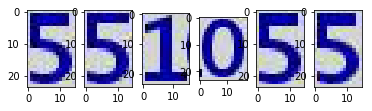

In [38]:
from matplotlib import pyplot as plt
fig = plt.figure()
for id, (_x,_y,_w,_h) in enumerate(ary):
    roi = open_cv_image[_y:_y+_h, _x:_x+_w]
    thresh = roi.copy()
    fig.add_subplot(1, len(ary), id+1)
    plt.imshow(thresh)

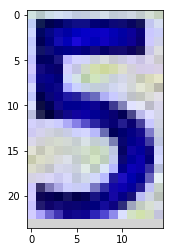

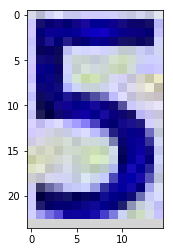

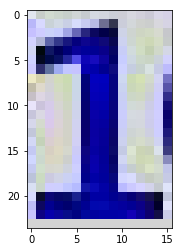

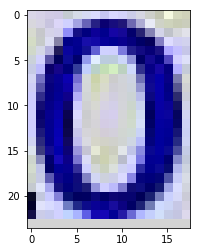

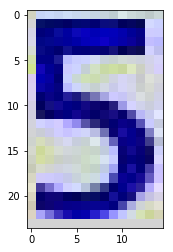

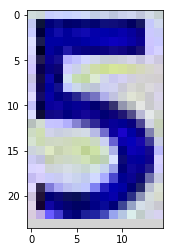

In [39]:
from matplotlib import pyplot as plt
import PIL

for id, (_x,_y,_w,_h) in enumerate(ary):
    fig = plt.figure()
    roi = open_cv_image[_y:_y+_h, _x:_x+_w]
    thresh = roi.copy()
    plt.imshow(thresh)
    plt.savefig('img/cnn_sample/pic_{}.jpg'.format(id+1), dpi=128)


Populating the interactive namespace from numpy and matplotlib


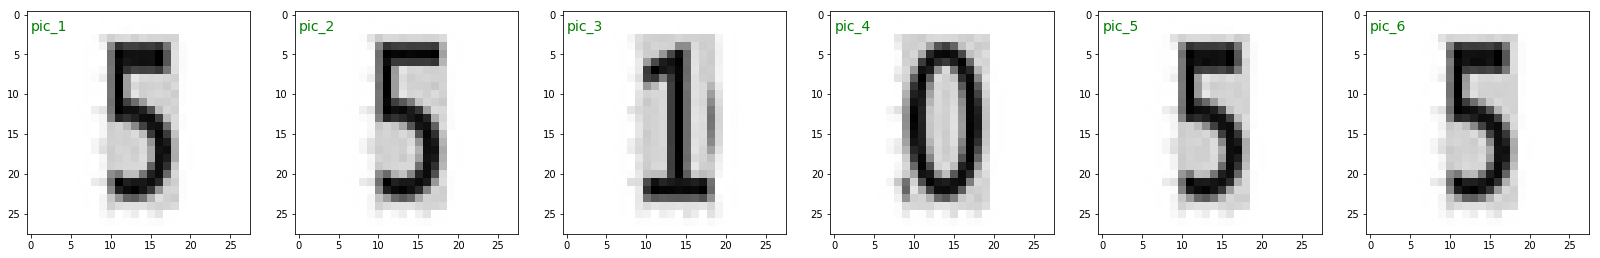

In [40]:
%pylab inline
import os

digits = []
fig = plt.figure(figsize = (28,28))
cnt = 0
for i in range(1,7):
    pil_image = PIL.Image.open('img/cnn_sample/pic_{}.jpg'.format(i)).convert('LA') #convert image to grayscale
    img = pil_image.resize((28, 28), PIL.Image.ANTIALIAS)
    
    ax = fig.add_subplot(1, 6, cnt+1)
    ax.imshow(img)
    ax.text(0, 2, 'pic_{}'.format(i), color="green", fontsize=14)
    cnt = cnt + 1

    digits.append([pixel for pixel in iter(img.getdata())])


In [41]:
import numpy
digit_ary = numpy.array(digits)

In [42]:
digit_ary.shape

(6, 784, 2)

In [43]:
d_ary = digit_ary[:,:,1] - digit_ary[:,:,0] #灰階減去負版, dim(6, 784, 2) to dim(6, 784) 

In [44]:
d_ary=d_ary/255

In [45]:
d_ary= np.array(d_ary, dtype='f')
#d_ary[0:1,]

In [46]:
#去除灰色背底: 0.2以下設為0
for i in range(0,6):
    d_ary[i,d_ary[i,]<0.2] = 0

INFO:tensorflow:Restoring parameters from save_model/cnn_model.ckpt


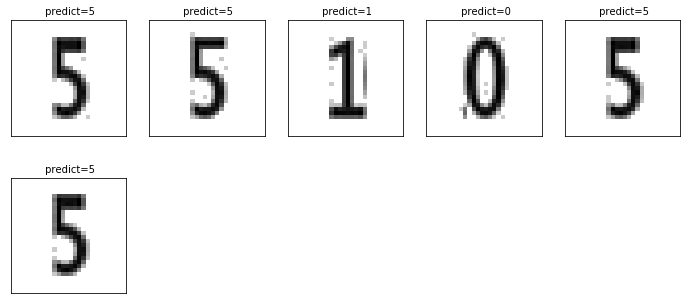

predict result: [5 5 1 0 5 5]


In [47]:

_imgs = d_ary
_labs = mnist.test.labels[0:6,]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Restore variables from disk.
    saver.restore(sess, "save_model/cnn_model.ckpt")
    pred_result = sess.run(tf.argmax(y_pred,1), feed_dict={x: _imgs, y: _labs})

    plot_images_labels_prediction(_imgs, [], pred_result,0,6)
    print("predict result:",pred_result)